In [ ]:
!pip3 uninstall -y keras

Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3


In [ ]:
!pip3 install keras==2.1.2

     |████████████████████████████████| 307kB 5.2MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.2 which is incompatible.


In [ ]:
!pip3 uninstall -y tensorflow

Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1


In [ ]:
!pip3 install tensorflow-gpu==1.14.0

     |████████████████████████████████| 377.1MB 48kB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 491kB 54.5MB/s 
     |████████████████████████████████| 3.2MB 37.2MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1


In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
"""
Some key layers used for constructing a Capsule Network. These layers can used to construct CapsNet on other dataset, 
not just on MNIST.
*NOTE*: some functions can be implemented in multiple ways, I keep all of them. You can try them for yourself just by
uncommenting them and commenting their counterparts.
Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

import keras.backend as K
from keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def __init__(self, **kwargs):
        super(Length, self).__init__(**kwargs)
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional 
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def __init__(self, **kwargs):
        super(Mask, self).__init__(**kwargs)
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]), elems=inputs_tiled)

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, dim=1)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))  # [None, 10, 16]

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding, name, count):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name=name)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name=name+'i'+ str(count))(output)
    return layers.Lambda(squash, name=name+ 'j' +str(count))(outputs)


"""
# The following is another way to implement primary capsule layer. This is much slower.
# Apply Conv2D `n_channels` times and concatenate all capsules
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    outputs = []
    for _ in range(n_channels):
        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
    outputs = layers.Concatenate(axis=1)(outputs)
    return layers.Lambda(squash)(outputs)
"""

Using TensorFlow backend.


'\n# The following is another way to implement primary capsule layer. This is much slower.\n# Apply Conv2D `n_channels` times and concatenate all capsules\ndef PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):\n    outputs = []\n    for _ in range(n_channels):\n        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)\n        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))\n    outputs = layers.Concatenate(axis=1)(outputs)\n    return layers.Lambda(squash)(outputs)\n'

In [ ]:
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical

In [ ]:
K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    Inputs = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv1')(Inputs)

    x = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    x = layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv2')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv3')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=128, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv4')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name="1", count=1)

    # primarycaps1 = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name = "2")

    # capsule = layers.concatenate([primarycaps, primarycaps1], axis=-1)

    # Layer 3: Capsule layer. Routing algorithm works here.
    # digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                            #  name='digitcaps')(primarycaps)
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)
    

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    # y = layers.Input(shape=(n_class,))
    # masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    # masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # # Shared Decoder model in training and prediction
    # decoder = models.Sequential(name='decoder')
    # decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    # decoder.add(layers.Dense(1024, activation='relu'))
    # decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    # decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    # train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    train_model = models.Model([Inputs], [out_caps])
    # eval_model = models.Model(x, [out_caps, decoder(masked)])
    eval_model = models.Model(Inputs, [out_caps])

    # manipulate model
    # noise = layers.Input(shape=(n_class, 16))
    # noised_digitcaps = layers.Add()([digitcaps, noise])
    # masked_noised_y = Mask()([noised_digitcaps, y])
    # manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    # return train_model, eval_model, manipulate_model
    return train_model,eval_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [ ]:
import os
import argparse
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

In [ ]:
model, eval_model = CapsNet(input_shape=(256,256,3), n_class=2, routings=6)
model.summary()






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 57, 57, 64)        51264     
__

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  
                  metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
import os
import math
import random
import tempfile

def _copy_symlinks(files, src_dir, dst_dir):
    for i in files:
        base_file_name = os.path.basename(i)
        src_file_path = os.path.join(src_dir, base_file_name)
        dst_file_path = os.path.join(dst_dir, base_file_name)
        src_file_path = os.path.abspath(src_file_path)
        dst_file_path = os.path.abspath(dst_file_path)
        os.symlink(src_file_path, dst_file_path)

def train_valid_split(original_dir, validation_split=0.1, seed=None):
    if seed is not None:
        random.seed(seed)    
    if not os.path.isdir(original_dir):
        raise NotADirectoryError
    tmp_dir = tempfile.TemporaryDirectory()
    train_dir = os.path.join(tmp_dir.name, 'train')
    valid_dir = os.path.join(tmp_dir.name, 'validation')

    # make subdirs in train tmp and valid tmp
    for root, dirs, files in os.walk(original_dir):
        if root == original_dir:
            continue
        sub_dir_name = os.path.basename(root)
        train_sub_dir_path = os.path.join(train_dir, sub_dir_name)
        valid_sub_dir_path = os.path.join(valid_dir, sub_dir_name)
        if not os.path.exists(train_sub_dir_path):
            os.makedirs(train_sub_dir_path)
        if not os.path.exists(valid_sub_dir_path):
            os.makedirs(valid_sub_dir_path)

    # distribute symlinks to train_tmp, test_tmp
    for root, dirs, files in os.walk(original_dir):
        if root == original_dir:
            continue
        sub_dir_name = os.path.basename(root)
        train_sub_dir_path = os.path.join(train_dir, sub_dir_name)
        valid_sub_dir_path = os.path.join(valid_dir, sub_dir_name)
        files = [os.path.join(root, f) for f in files]
        random.shuffle(files)
        valid_idx = math.ceil(validation_split * len(files))
        train_files = files[valid_idx:]
        valid_files = files[:valid_idx]
        _copy_symlinks(train_files, root, train_sub_dir_path)
        _copy_symlinks(valid_files, root, valid_sub_dir_path)
    return tmp_dir, train_dir, valid_dir

In [ ]:

original_dir = '/content/drive/MyDrive/XRAY'
batch_size = 32
validation_split = 0.25

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
train_generator=datagen.flow_from_directory(directory=train_dir,batch_size=32)
test_generator=datagen.flow_from_directory(directory=val_dir,batch_size=32, shuffle=False)
# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(train_generator,
                    epochs=15)
y_true = test_generator.classes

result = model.predict_generator(test_generator)

y_pred = np.argmax(result, axis=-1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))
#model.save("/content/drive/My Drive/capsCovid_epoch10.h5") renamed in drive to model.save("/content/drive/My Drive/capsCovid_epoch15.h5")
model.save("/content/drive/My Drive/capsCovid_1_capsule_epoch15.h5")

Found 1933 images belonging to 2 classes.
Found 646 images belonging to 2 classes.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/15
61/61 [==============================] - 504s 8s/step - loss: 0.8164 - acc: 0.6036
Epoch 2/15
61/61 [==============================] - 61s 1s/step - loss: 0.6380 - acc: 0.6618
Epoch 3/15
61/61 [==============================] - 61s 1s/step - loss: 0.5697 - acc: 0.6988
Epoch 4/15
61/61 [==============================] - 61s 999ms/step - loss: 0.4433 - acc: 0.8045
Epoch 5/15
61/61 [==============================] - 61s 1000ms/step - loss: 0.3663 - acc: 0.8561
Epoch 6/15
61/61 [==============================] - 61s 1s/step - loss: 0.3363 - acc: 0.8735
Epoch 7/15
61/61 [==============================] - 61s 998ms/step - loss: 0.2818 - acc: 0.8991
Epoch 8/15
61/61 [==============================] - 61s 1s/step - loss: 0.2796 - acc: 0.8987
Epoch 9/15
61/61 [=========================

In [ ]:
K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    Inputs = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv1')(Inputs)

    x = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    x = layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv2')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv3')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=128, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv4')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name="1", count=1)

    primarycaps1 = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name = "2", count=2)

    capsule = layers.concatenate([primarycaps, primarycaps1], axis=-1)

    # Layer 3: Capsule layer. Routing algorithm works here.
    # digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                            #  name='digitcaps')(primarycaps)
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(capsule)
    

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    # y = layers.Input(shape=(n_class,))
    # masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    # masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # # Shared Decoder model in training and prediction
    # decoder = models.Sequential(name='decoder')
    # decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    # decoder.add(layers.Dense(1024, activation='relu'))
    # decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    # decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    # train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    train_model = models.Model([Inputs], [out_caps])
    # eval_model = models.Model(x, [out_caps, decoder(masked)])
    eval_model = models.Model(Inputs, [out_caps])

    # manipulate model
    # noise = layers.Input(shape=(n_class, 16))
    # noised_digitcaps = layers.Add()([digitcaps, noise])
    # masked_noised_y = Mask()([noised_digitcaps, y])
    # manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    # return train_model, eval_model, manipulate_model
    return train_model,eval_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [ ]:
model, eval_model = CapsNet(input_shape=(256,256,3), n_class=2, routings=6)
model.summary()






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 252, 252, 16) 1216        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 126, 126, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 122, 122, 32) 12832       max

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  
                  metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:

original_dir = '/content/drive/MyDrive/XRAY'
batch_size = 32
validation_split = 0.25

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
train_generator=datagen.flow_from_directory(directory=train_dir,batch_size=32)
test_generator=datagen.flow_from_directory(directory=val_dir,batch_size=32, shuffle=False)
# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(train_generator,
                    epochs=15)
y_true = test_generator.classes

result = model.predict_generator(test_generator)

y_pred = np.argmax(result, axis=-1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))
#model.save("/content/drive/My Drive/capsCovid_epoch10.h5") renamed in drive to model.save("/content/drive/My Drive/capsCovid_epoch15.h5")
model.save("/content/drive/My Drive/capsCovid_2_capsule_epoch15.h5")

Found 1933 images belonging to 2 classes.
Found 646 images belonging to 2 classes.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/15
61/61 [==============================] - 63s 1s/step - loss: 0.8176 - acc: 0.6190
Epoch 2/15
61/61 [==============================] - 61s 1s/step - loss: 0.5338 - acc: 0.7271
Epoch 3/15
61/61 [==============================] - 61s 1s/step - loss: 0.4183 - acc: 0.8284
Epoch 4/15
61/61 [==============================] - 61s 1s/step - loss: 0.3603 - acc: 0.8532
Epoch 5/15
61/61 [==============================] - 62s 1s/step - loss: 0.2735 - acc: 0.8979
Epoch 6/15
61/61 [==============================] - 61s 998ms/step - loss: 0.2266 - acc: 0.9144
Epoch 7/15
61/61 [==============================] - 61s 998ms/step - loss: 0.2119 - acc: 0.9290
Epoch 8/15
61/61 [==============================] - 62s 1s/step - loss: 0.2098 - acc: 0.9274
Epoch 9/15
61/61 [==============================

In [ ]:
K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    Inputs = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv1')(Inputs)

    x = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    x = layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv2')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv3')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=128, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv4')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name="1", count=1)

    primarycaps1 = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name = "2", count=2)

    primarycaps2 = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name = "3", count=3)

    capsule = layers.concatenate([primarycaps, primarycaps1, primarycaps2], axis=-1)

    # Layer 3: Capsule layer. Routing algorithm works here.
    # digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                            #  name='digitcaps')(primarycaps)
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=8, routings=routings,
                             name='digitcaps')(capsule)
    

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    # y = layers.Input(shape=(n_class,))
    # masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    # masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # # Shared Decoder model in training and prediction
    # decoder = models.Sequential(name='decoder')
    # decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    # decoder.add(layers.Dense(1024, activation='relu'))
    # decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    # decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    # train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    train_model = models.Model([Inputs], [out_caps])
    # eval_model = models.Model(x, [out_caps, decoder(masked)])
    eval_model = models.Model(Inputs, [out_caps])

    # manipulate model
    # noise = layers.Input(shape=(n_class, 16))
    # noised_digitcaps = layers.Add()([digitcaps, noise])
    # masked_noised_y = Mask()([noised_digitcaps, y])
    # manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    # return train_model, eval_model, manipulate_model
    return train_model,eval_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [ ]:
model, eval_model = CapsNet(input_shape=(256,256,3), n_class=2, routings=6)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 252, 252, 16) 1216        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 126, 126, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 122, 122, 32) 12832       max_pooling2d_10[0][0]           
__________________________________________________________________________________________________
max_poolin

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  
                  metrics=['accuracy'])

In [ ]:

original_dir = '/content/drive/MyDrive/XRAY'
batch_size = 32
validation_split = 0.25

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
train_generator=datagen.flow_from_directory(directory=train_dir,batch_size=32)
test_generator=datagen.flow_from_directory(directory=val_dir,batch_size=32, shuffle=False)
# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(train_generator,
                    epochs=15)
y_true = test_generator.classes

result = model.predict_generator(test_generator)

y_pred = np.argmax(result, axis=-1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))
#model.save("/content/drive/My Drive/capsCovid_epoch10.h5") renamed in drive to model.save("/content/drive/My Drive/capsCovid_epoch15.h5")
model.save("/content/drive/My Drive/capsCovid_3_capsule_epoch15.h5")

Found 1933 images belonging to 2 classes.
Found 646 images belonging to 2 classes.
Epoch 1/15
61/61 [==============================] - 62s 1s/step - loss: 1.0744 - acc: 0.5580
Epoch 2/15
61/61 [==============================] - 61s 1s/step - loss: 0.6738 - acc: 0.6370
Epoch 3/15
61/61 [==============================] - 61s 1s/step - loss: 0.5252 - acc: 0.7336
Epoch 4/15
61/61 [==============================] - 61s 1s/step - loss: 0.4365 - acc: 0.8134
Epoch 5/15
61/61 [==============================] - 62s 1s/step - loss: 0.3440 - acc: 0.8757
Epoch 6/15
61/61 [==============================] - 61s 1s/step - loss: 0.3371 - acc: 0.8697
Epoch 7/15
61/61 [==============================] - 61s 1s/step - loss: 0.2668 - acc: 0.9036
Epoch 8/15
61/61 [==============================] - 61s 1s/step - loss: 0.2764 - acc: 0.9005
Epoch 9/15
61/61 [==============================] - 61s 1s/step - loss: 0.2260 - acc: 0.9241
Epoch 10/15
61/61 [==============================] - 61s 1s/step - loss: 0.2166 

In [ ]:
K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    Inputs = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv1')(Inputs)

    x = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    x = layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv2')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv3')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=128, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv4')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name="1", count=1)

    primarycaps1 = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name = "2", count=2)

    primarycaps2 = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name = "3", count=3)

    primarycaps3 = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid', name = "4", count=4)

    capsule = layers.concatenate([primarycaps, primarycaps1, primarycaps2, primarycaps3], axis=-1)

    # Layer 3: Capsule layer. Routing algorithm works here.
    # digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                            #  name='digitcaps')(primarycaps)
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=8, routings=routings,
                             name='digitcaps')(capsule)
    

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    # y = layers.Input(shape=(n_class,))
    # masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    # masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # # Shared Decoder model in training and prediction
    # decoder = models.Sequential(name='decoder')
    # decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    # decoder.add(layers.Dense(1024, activation='relu'))
    # decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    # decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    # train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    train_model = models.Model([Inputs], [out_caps])
    # eval_model = models.Model(x, [out_caps, decoder(masked)])
    eval_model = models.Model(Inputs, [out_caps])

    # manipulate model
    # noise = layers.Input(shape=(n_class, 16))
    # noised_digitcaps = layers.Add()([digitcaps, noise])
    # masked_noised_y = Mask()([noised_digitcaps, y])
    # manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    # return train_model, eval_model, manipulate_model
    return train_model,eval_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [ ]:
model, eval_model = CapsNet(input_shape=(256,256,3), n_class=2, routings=6)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 252, 252, 16) 1216        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 126, 126, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 122, 122, 32) 12832       max_pooling2d_13[0][0]           
__________________________________________________________________________________________________
max_poolin

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  
                  metrics=['accuracy'])

In [ ]:

original_dir = '/content/drive/MyDrive/XRAY'
batch_size = 32
validation_split = 0.25

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
train_generator=datagen.flow_from_directory(directory=train_dir,batch_size=32)
test_generator=datagen.flow_from_directory(directory=val_dir,batch_size=32, shuffle=False)
# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(train_generator,
                    epochs=15)
y_true = test_generator.classes

result = model.predict_generator(test_generator)

y_pred = np.argmax(result, axis=-1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))
#model.save("/content/drive/My Drive/capsCovid_epoch10.h5") renamed in drive to model.save("/content/drive/My Drive/capsCovid_epoch15.h5")
model.save("/content/drive/My Drive/capsCovid_4_capsule_epoch15.h5")

Found 1933 images belonging to 2 classes.
Found 646 images belonging to 2 classes.
Epoch 1/15
61/61 [==============================] - 62s 1s/step - loss: 0.8839 - acc: 0.6141
Epoch 2/15
61/61 [==============================] - 61s 1s/step - loss: 0.4741 - acc: 0.7856
Epoch 3/15
61/61 [==============================] - 61s 1000ms/step - loss: 0.3680 - acc: 0.8524
Epoch 4/15
61/61 [==============================] - 61s 997ms/step - loss: 0.3298 - acc: 0.8678
Epoch 5/15
61/61 [==============================] - 61s 1s/step - loss: 0.2656 - acc: 0.9055
Epoch 6/15
61/61 [==============================] - 61s 1s/step - loss: 0.2480 - acc: 0.9129
Epoch 7/15
61/61 [==============================] - 61s 1s/step - loss: 0.2039 - acc: 0.9315
Epoch 8/15
61/61 [==============================] - 61s 1s/step - loss: 0.1720 - acc: 0.9482
Epoch 9/15
61/61 [==============================] - 61s 1s/step - loss: 0.1726 - acc: 0.9487
Epoch 10/15
61/61 [==============================] - 61s 1s/step - loss: 

In [ ]:
!pip3 install keras==2.2.4

     |████████████████████████████████| 317kB 14.6MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.


In [ ]:
K.set_image_data_format('channels_last')

from keras.layers import Dense, Flatten
def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    Inputs = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv1')(Inputs)

    x = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    x = layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv2')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv3')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=128, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv4')(x)

    x = Flatten()(x)

    
    out_caps = Dense(2, activation='sigmoid')(x)

    
    train_model = models.Model([Inputs], [out_caps])
    # eval_model = models.Model(x, [out_caps, decoder(masked)])
    eval_model = models.Model(Inputs, [out_caps])

    # manipulate model
    # noise = layers.Input(shape=(n_class, 16))
    # noised_digitcaps = layers.Add()([digitcaps, noise])
    # masked_noised_y = Mask()([noised_digitcaps, y])
    # manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    # return train_model, eval_model, manipulate_model
    return train_model,eval_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [ ]:
model, eval_model = CapsNet(input_shape=(256,256,3), n_class=2, routings=6)
model.summary()


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 126, 126, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 57, 57, 64)        51264     
_________________________________________________________________
max

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  
                  metrics=['accuracy'])

In [ ]:

original_dir = '/content/drive/MyDrive/XRAY'
batch_size = 32
validation_split = 0.25

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
train_generator=datagen.flow_from_directory(directory=train_dir,batch_size=32)
test_generator=datagen.flow_from_directory(directory=val_dir,batch_size=32, shuffle=False)
# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(train_generator,
                    epochs=15)
y_true = test_generator.classes

result = model.predict_generator(test_generator)

y_pred = np.argmax(result, axis=-1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))
#model.save("/content/drive/My Drive/capsCovid_epoch10.h5") renamed in drive to model.save("/content/drive/My Drive/capsCovid_epoch15.h5")
model.save("/content/drive/My Drive/cnnCovid_epoch15.h5")

Found 1933 images belonging to 2 classes.
Found 646 images belonging to 2 classes.
Epoch 1/15
61/61 [==============================] - 62s 1s/step - loss: 0.6249 - acc: 0.7103
Epoch 2/15
61/61 [==============================] - 60s 982ms/step - loss: 0.3816 - acc: 0.8563
Epoch 3/15
61/61 [==============================] - 60s 978ms/step - loss: 0.3685 - acc: 0.8586
Epoch 4/15
61/61 [==============================] - 60s 984ms/step - loss: 0.3064 - acc: 0.8815
Epoch 5/15
61/61 [==============================] - 60s 981ms/step - loss: 0.2404 - acc: 0.9081
Epoch 6/15
61/61 [==============================] - 60s 979ms/step - loss: 0.2246 - acc: 0.9085
Epoch 7/15
61/61 [==============================] - 60s 979ms/step - loss: 0.2061 - acc: 0.9232
Epoch 8/15
61/61 [==============================] - 59s 972ms/step - loss: 0.1852 - acc: 0.9306
Epoch 9/15
61/61 [==============================] - 59s 974ms/step - loss: 0.1653 - acc: 0.9426
Epoch 10/15
61/61 [==============================] - 59s

In [ ]:
from keras import backend as K
import tensorflow as tf
import numpy as np
from keras import layers, initializers, regularizers, constraints
from keras.utils import conv_utils
from keras.layers import InputSpec
from keras.utils.conv_utils import conv_output_length
import keras.backend.tensorflow_backend as tfback

from keras.backend import *
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops


#own_batch_dot = batch_dot  # force standard implementation 

# import of batch_dot operation from TF 1.13
# https://github.com/tensorflow/tensorflow/blob/v1.13.1/tensorflow/python/keras/backend.py

def own_batch_dot(x, y, axes=None):
    """Batchwise dot product.
    `batch_dot` is used to compute dot product of `x` and `y` when
    `x` and `y` are data in batch, i.e. in a shape of
    `(batch_size, :)`.
    `batch_dot` results in a tensor or variable with less dimensions
    than the input. If the number of dimensions is reduced to 1,
    we use `expand_dims` to make sure that ndim is at least 2.
    Arguments:
        x: Keras tensor or variable with `ndim >= 2`.
        y: Keras tensor or variable with `ndim >= 2`.
        axes: list of (or single) int with target dimensions.
            The lengths of `axes[0]` and `axes[1]` should be the same.
    Returns:
        A tensor with shape equal to the concatenation of `x`'s shape
        (less the dimension that was summed over) and `y`'s shape
        (less the batch dimension and the dimension that was summed over).
        If the final rank is 1, we reshape it to `(batch_size, 1)`.
    Examples:
        Assume `x = [[1, 2], [3, 4]]` and `y = [[5, 6], [7, 8]]`
        `batch_dot(x, y, axes=1) = [[17, 53]]` which is the main diagonal
        of `x.dot(y.T)`, although we never have to calculate the off-diagonal
        elements.
        Shape inference:
        Let `x`'s shape be `(100, 20)` and `y`'s shape be `(100, 30, 20)`.
        If `axes` is (1, 2), to find the output shape of resultant tensor,
            loop through each dimension in `x`'s shape and `y`'s shape:
        * `x.shape[0]` : 100 : append to output shape
        * `x.shape[1]` : 20 : do not append to output shape,
            dimension 1 of `x` has been summed over. (`dot_axes[0]` = 1)
        * `y.shape[0]` : 100 : do not append to output shape,
            always ignore first dimension of `y`
        * `y.shape[1]` : 30 : append to output shape
        * `y.shape[2]` : 20 : do not append to output shape,
            dimension 2 of `y` has been summed over. (`dot_axes[1]` = 2)
        `output_shape` = `(100, 30)`
    ```python
        >>> x_batch = K.ones(shape=(32, 20, 1))
        >>> y_batch = K.ones(shape=(32, 30, 20))
        >>> xy_batch_dot = K.batch_dot(x_batch, y_batch, axes=[1, 2])
        >>> K.int_shape(xy_batch_dot)
        (32, 1, 30)
    ```
    """
    if isinstance(axes, int):
        axes = (axes, axes)
    x_ndim = ndim(x)
    y_ndim = ndim(y)
    if axes is None:
      # behaves like tf.batch_matmul as default
        axes = [x_ndim - 1, y_ndim - 2]
    if x_ndim > y_ndim:
        diff = x_ndim - y_ndim
        y = array_ops.reshape(y,
                            array_ops.concat(
                                [array_ops.shape(y), [1] * (diff)], axis=0))
    elif y_ndim > x_ndim:
        diff = y_ndim - x_ndim
        x = array_ops.reshape(x,
                            array_ops.concat(
                                [array_ops.shape(x), [1] * (diff)], axis=0))
    else:
        diff = 0
    if ndim(x) == 2 and ndim(y) == 2:
        if axes[0] == axes[1]:
          out = math_ops.reduce_sum(math_ops.multiply(x, y), axes[0])
        else:
          out = math_ops.reduce_sum(math_ops.multiply(array_ops.transpose(x, [1, 0]), y), axes[1])
    else:
        adj_x = None if axes[0] == ndim(x) - 1 else True
        adj_y = True if axes[1] == ndim(y) - 1 else None
        if adj_x==True:
          x = tf.transpose(x, conjugate=True)
        if adj_y==True:
          y = tf.transpose(y, conjugate=True)
        # out = math_ops.matmul(x, y, adjoint_a=adj_x, adjoint_b=adj_y)
        out = tf.tensordot(x, y, axes=1)
    if diff:
        if x_ndim > y_ndim:
          idx = x_ndim + y_ndim - 3
        else:
          idx = x_ndim - 1
        out = array_ops.squeeze(out, list(range(idx, idx + diff)))
    if ndim(out) == 1:
        out = expand_dims(out, 1)
    return out

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    
    return [tf.test.gpu_device_name()]

tfback._get_available_gpus = _get_available_gpus

cf = K.image_data_format() == '..'
useGPU = True


def squeeze(s):
    sq = K.sum(K.square(s), axis=-1, keepdims=True)
    return (sq / (1 + sq)) * (s / K.sqrt(sq + K.epsilon()))


class ConvertToCaps(layers.Layer):

    def __init__(self, **kwargs):
        super(ConvertToCaps, self).__init__(**kwargs)
        # self.input_spec = InputSpec(min_ndim=2)

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape.insert(1 if cf else len(output_shape), 1)
        return tuple(output_shape)

    def call(self, inputs):
        return K.expand_dims(inputs, 1 if cf else -1)

    def get_config(self):
        # config = {
        #     'input_spec': 5
        # }
        base_config = super(ConvertToCaps, self).get_config()
        return base_config


class FlattenCaps(layers.Layer):

    def __init__(self, **kwargs):
        super(FlattenCaps, self).__init__(**kwargs)
        self.input_spec = InputSpec(min_ndim=4)

    def compute_output_shape(self, input_shape):
        # if not all(input_shape[1:]):
        #     raise ValueError('The shape of the input to "FlattenCaps" '
        #                      'is not fully defined '
        #                      '(got ' + str(input_shape[1:]) + '. '
        #                      'Make sure to pass a complete "input_shape" '
        #                      'or "batch_input_shape" argument to the first '
        #                      'layer in your model.')
        return (input_shape[0], np.prod(input_shape[1:-1]), input_shape[-1])

    def call(self, inputs):
        shape = K.int_shape(inputs)
        return K.reshape(inputs, (-1, np.prod(shape[1:-1]), shape[-1]))
    def get_config(self):
        # config = {
        #       'input_spec': 5
        #   }
        base_config = super(FlattenCaps, self).get_config()
        # return dict(list(base_config.items()) + list(config.items()))
        return base_config


class CapsToScalars(layers.Layer):

    def __init__(self, **kwargs):
        super(CapsToScalars, self).__init__(**kwargs)
        self.input_spec = InputSpec(min_ndim=3)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

    def call(self, inputs):
        return K.sqrt(K.sum(K.square(inputs + K.epsilon()), axis=-1))
    
    def get_config(self):
        # config = {
        #       'input_spec': 5
        #   }
        base_config = super(CapsToScalars, self).get_config()
        # return dict(list(base_config.items()) + list(config.items()))
        return base_config

class Conv2DCaps(layers.Layer):

    def __init__(self, ch_j, n_j,
                 kernel_size=(3, 3),
                 strides=(1, 1),
                 r_num=1,
                 b_alphas=[8, 8, 8],
                 padding='same',
                 data_format='channels_last',
                 dilation_rate=(1, 1),
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 **kwargs):
        super(Conv2DCaps, self).__init__(**kwargs)
        rank = 2
        self.ch_j = ch_j  # Number of capsules in layer J
        self.n_j = n_j  # Number of neurons in a capsule in J
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, rank, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, rank, 'strides')
        self.r_num = r_num
        self.b_alphas = b_alphas
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = K.normalize_data_format(data_format)
        self.dilation_rate = (1, 1)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.input_spec = InputSpec(ndim=rank + 3)

    def build(self, input_shape):

        self.h_i, self.w_i, self.ch_i, self.n_i = input_shape[1:5]

        self.h_j, self.w_j = [conv_utils.conv_output_length(input_shape[i + 1],
                                                            self.kernel_size[i],
                                                            padding=self.padding,
                                                            stride=self.strides[i],
                                                            dilation=self.dilation_rate[i]) for i in (0, 1)]

        self.ah_j, self.aw_j = [conv_utils.conv_output_length(input_shape[i + 1],
                                                              self.kernel_size[i],
                                                              padding=self.padding,
                                                              stride=1,
                                                              dilation=self.dilation_rate[i]) for i in (0, 1)]

        self.w_shape = self.kernel_size + (self.ch_i, self.n_i,
                                           self.ch_j, self.n_j)

        self.w = self.add_weight(shape=self.w_shape,
                                 initializer=self.kernel_initializer,
                                 name='kernel',
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)

        self.built = True

    def call(self, inputs):
        if self.r_num == 1:
            # if there is no routing (and this is so when r_num is 1 and all c are equal)
            # then this is a common convolution
            outputs = K.conv2d(K.reshape(inputs, (-1, self.h_i, self.w_i,
                                                  self.ch_i * self.n_i)),
                               K.reshape(self.w, self.kernel_size +
                                         (self.ch_i * self.n_i, self.ch_j * self.n_j)),
                               data_format='channels_last',
                               strides=self.strides,
                               padding=self.padding,
                               dilation_rate=self.dilation_rate)

            outputs = squeeze(K.reshape(outputs, ((-1, self.h_j, self.w_j,
                                                   self.ch_j, self.n_j))))

        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.h_j, self.w_j, self.ch_j, self.n_j)

    def get_config(self):
        config = {
            'ch_j': self.ch_j,
            'n_j': self.n_j,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'b_alphas': self.b_alphas,
            'padding': self.padding,
            'data_format': self.data_format,
            'dilation_rate': self.dilation_rate,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint)
        }
        base_config = super(Conv2DCaps, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class Mask(layers.Layer):

    def call(self, inputs, **kwargs):
        if isinstance(inputs, list):  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.one_hot(indices=K.argmax(x, 1), num_classes=x.get_shape().as_list()[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * K.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape[0], tuple):  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])
    def get_config(self):
        
        base_config = super(Mask, self).get_config()
        return base_config


class Mask_CID(layers.Layer):

    def call(self, inputs, **kwargs):
        if isinstance(inputs, list):  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, a = inputs
            mask = K.argmax(a, 1)
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = K.sqrt(K.sum(K.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = K.argmax(x, 1)

        increasing = tf.range(start=0, limit=tf.shape(inputs)[0], delta=1)
        m = tf.stack([increasing, tf.cast(mask, tf.int32)], axis=1)
        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        # x1 = tf.transpose(inputs, (0))
        masked = tf.gather_nd(inputs, m)

        return masked

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape[0], tuple):  # true label provided
            return tuple([None, input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[2]])
    def get_config(self):
       
        base_config = super(Mask_CID, self).get_config()
        return base_config


class ConvCapsuleLayer3D(layers.Layer):

    def __init__(self, kernel_size, num_capsule, num_atoms, strides=1, padding='valid', routings=3,
                 kernel_initializer='he_normal', **kwargs):
        super(ConvCapsuleLayer3D, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        self.num_capsule = num_capsule
        self.num_atoms = num_atoms
        self.strides = strides
        self.padding = padding
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) == 5, "The input Tensor should have shape=[None, input_height, input_width," \
                                      " input_num_capsule, input_num_atoms]"
        self.input_height = input_shape[1]
        self.input_width = input_shape[2]
        self.input_num_capsule = input_shape[3]
        self.input_num_atoms = input_shape[4]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_atoms, self.kernel_size, self.kernel_size, 1, self.num_capsule * self.num_atoms],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.b = self.add_weight(shape=[self.num_capsule, self.num_atoms, 1, 1],
                                 initializer=initializers.constant(0.1),
                                 name='b')

        self.built = True

    def call(self, input_tensor, training=None):

        input_transposed = tf.transpose(input_tensor, [0, 3, 4, 1, 2])
        input_shape = K.shape(input_transposed)
        input_tensor_reshaped = K.reshape(input_tensor, [input_shape[0], 1, self.input_num_capsule * self.input_num_atoms, self.input_height, self.input_width])

        input_tensor_reshaped.set_shape((None, 1, self.input_num_capsule * self.input_num_atoms, self.input_height, self.input_width))

        # conv = Conv3D(input_tensor_reshaped, self.W, (self.strides, self.strides),
        #                 padding=self.padding, data_format='channels_first')

        conv = K.conv3d(input_tensor_reshaped, self.W, strides=(self.input_num_atoms, self.strides, self.strides), padding=self.padding, data_format='channels_first')

        votes_shape = K.shape(conv)
        _, _, _, conv_height, conv_width = conv.get_shape()
        conv = tf.transpose(conv, [0, 2, 1, 3, 4])
        votes = K.reshape(conv, [input_shape[0], self.input_num_capsule, self.num_capsule, self.num_atoms, votes_shape[3], votes_shape[4]])
        votes.set_shape((None, self.input_num_capsule, self.num_capsule, self.num_atoms, conv_height, conv_width))
        # votes.set_shape((None, self.input_num_capsule, self.num_capsule, self.num_atoms, conv_height.value, conv_width.value))

        logit_shape = K.stack([input_shape[0], self.input_num_capsule, self.num_capsule, votes_shape[3], votes_shape[4]])
        biases_replicated = K.tile(self.b, [1, 1, conv_height, conv_width])
        # biases_replicated = K.tile(self.b, [1, 1, conv_height.value, conv_width.value])

        activations = update_routing(
            votes=votes,
            biases=biases_replicated,
            logit_shape=logit_shape,
            num_dims=6,
            input_dim=self.input_num_capsule,
            output_dim=self.num_capsule,
            num_routing=self.routings)

        a2 = tf.transpose(activations, [0, 3, 4, 1, 2])
        return a2

    def compute_output_shape(self, input_shape):
        space = input_shape[1:-2]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_output_length(space[i], self.kernel_size, padding=self.padding, stride=self.strides, dilation=1)
            new_space.append(new_dim)

        return (input_shape[0],) + tuple(new_space) + (self.num_capsule, self.num_atoms)

    def get_config(self):
        config = {
            'kernel_size': self.kernel_size,
            'num_capsule': self.num_capsule,
            'num_atoms': self.num_atoms,
            'strides': self.strides,
            'padding': self.padding,
            'routings': self.routings,
            'kernel_initializer': initializers.serialize(self.kernel_initializer)
        }
        base_config = super(ConvCapsuleLayer3D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def update_routing(votes, biases, logit_shape, num_dims, input_dim, output_dim,
                   num_routing):
    if num_dims == 6:
        votes_t_shape = [3, 0, 1, 2, 4, 5]
        r_t_shape = [1, 2, 3, 0, 4, 5]
    elif num_dims == 4:
        votes_t_shape = [3, 0, 1, 2]
        r_t_shape = [1, 2, 3, 0]
    else:
        raise NotImplementedError('Not implemented')

    votes_trans = tf.transpose(votes, votes_t_shape)
    _, _, _, height, width, caps = votes_trans.get_shape()

    def _body(i, logits, activations):
        """Routing while loop."""
        # route: [batch, input_dim, output_dim, ...]
        a,b,c,d,e = logits.get_shape()
        a = logit_shape[0]
        b = logit_shape[1]
        c = logit_shape[2]
        d = logit_shape[3]
        e = logit_shape[4]
        print(logit_shape)
        logit_temp = tf.reshape(logits, [a,b,-1])
        route_temp = tf.nn.softmax(logit_temp, axis=-1)
        route = tf.reshape(route_temp, [a, b, c, d, e])
        preactivate_unrolled = route * votes_trans
        preact_trans = tf.transpose(preactivate_unrolled, r_t_shape)
        preactivate = tf.reduce_sum(preact_trans, axis=1) + biases
        activation = _squash(preactivate)
        activations = activations.write(i, activation)

        act_3d = K.expand_dims(activation, 1)
        tile_shape = np.ones(num_dims, dtype=np.int32).tolist()
        tile_shape[1] = input_dim
        act_replicated = tf.tile(act_3d, tile_shape)
        distances = tf.reduce_sum(votes * act_replicated, axis=3)
        logits += distances
        return (i + 1, logits, activations)

    activations = tf.TensorArray(
        dtype=tf.float32, size=num_routing, clear_after_read=False)
    logits = tf.fill(logit_shape, 0.0)

    # shape_invariants_var = [tf.TensorShape([]),
    #                          logits.get_shape(),
    #                         votes_trans.get_shape()]

    i = tf.constant(0, dtype=tf.int32)
    _, logits, activations = tf.while_loop(
        lambda i, logits, activations: i < num_routing,
        _body,
        loop_vars=[i, logits, activations],
        swap_memory=True)
    a = K.cast(activations.read(num_routing - 1), dtype='float32')
    return K.cast(activations.read(num_routing - 1), dtype='float32')


class DenseCaps(layers.Layer):

    def __init__(self, ch_j, n_j,
                 r_num=1,
                 b_alphas=[8, 8, 8],
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(DenseCaps, self).__init__(**kwargs)
        self.ch_j = ch_j  # number of capsules in layer J
        self.n_j = n_j  # number of neurons in a capsule in J
        self.r_num = r_num
        self.b_alphas = b_alphas
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.input_spec = InputSpec(min_ndim=3)
        self.supports_masking = True

    def build(self, input_shape):
        self.ch_i, self.n_i = input_shape[1:]

        self.w_shape = (self.ch_i, self.n_i, self.ch_j, self.n_j)

        self.w = self.add_weight(shape=self.w_shape,
                                 initializer=self.kernel_initializer,
                                 name='kernel',
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)

        self.built = True

    def call(self, inputs):
        if self.r_num == 1:
            outputs = K.dot(K.reshape(inputs, (-1, self.ch_i * self.n_i)),
                            K.reshape(self.w, (self.ch_i * self.n_i,
                                               self.ch_j * self.n_j)))
            outputs = squeeze(K.reshape(outputs, (-1, self.ch_j, self.n_j)))
        else:
            wr = K.reshape(self.w, (self.ch_i, self.n_i, self.ch_j * self.n_j))

            u = tf.transpose(tf.matmul(tf.transpose(inputs, [1, 0, 2]), wr), [1, 0, 2])

            u = K.reshape(u, (-1, self.ch_i, self.ch_j, self.n_j))

            def rt(ub):
                ub = K.reshape(ub, (-1, self.ch_i, self.ch_j, self.n_j))
                ub_wo_g = K.stop_gradient(ub)
                b = 0.0
                for r in range(self.r_num):
                    if r > 0:
                        c = K.expand_dims(K.softmax(b * self.b_alphas[r])) * self.ch_j  # distribution of weighs of capsules in I across capsules in J
                        c = K.stop_gradient(c)
                    else:
                        c = 1.0

                    if r == self.r_num - 1:
                        cub = c * ub
                    else:
                        cub = c * ub_wo_g
                    s = K.sum(cub, axis=-3)  # vectors of capsules in J
                    v = squeeze(s)  # squeezed vectors of capsules in J
                    if r == self.r_num - 1:
                        break

                    v = K.stop_gradient(v)

                    a = tf.einsum('bjk,bijk->bij', v, ub)  # a = v dot u
                    # a = K.matmul(K.reshape(v, (-1, 1, J, 1, n_j)),
                    #             K.reshape(u, (-1, I, J, n_j, 1))).reshape((-1, I, J))

                    b = b + a  # increase those b[i,j] where v[j] dot b[i,j] is larger
                return v

            u = K.reshape(u, (-1, self.ch_i * self.ch_j * self.n_j))

            global useGPU

            if useGPU:
                outputs = rt(u)
            else:
                outputs = tf.map_fn(rt, u,
                                    parallel_iterations=100, back_prop=True,
                                    infer_shape=False)

            outputs = K.reshape(outputs, (-1, self.ch_j, self.n_j))

        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.ch_j, self.n_j)

    def get_config(self):
        config = {
            'ch_j': self.ch_j,
            'n_j': self.n_j,
            'r_num': self.r_num,
            'b_alphas': self.b_alphas,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
        }
        base_config = super(DenseCaps, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class CapsuleLayer(layers.Layer):

    def __init__(self, num_capsule, dim_capsule, channels, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.channels = channels
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        if(self.channels != 0):
            assert int(self.input_num_capsule / self.channels) / (self.input_num_capsule / self.channels) == 1, "error"
            self.W = self.add_weight(shape=[self.num_capsule, self.channels,
                                            self.dim_capsule, self.input_dim_capsule],
                                     initializer=self.kernel_initializer,
                                     name='W')

            self.B = self.add_weight(shape=[self.num_capsule, self.dim_capsule],
                                     initializer=self.kernel_initializer,
                                     name='B')
        else:
            self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                            self.dim_capsule, self.input_dim_capsule],
                                     initializer=self.kernel_initializer,
                                     name='W')
            self.B = self.add_weight(shape=[self.num_capsule, self.dim_capsule],
                                     initializer=self.kernel_initializer,
                                     name='B')

        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        if(self.channels != 0):
            W2 = K.repeat_elements(self.W, int(self.input_num_capsule / self.channels), 1)
        else:
            W2 = self.W
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]


        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, W2, [2, 3]), elems=inputs_tiled)

        # inputs_hat = K.map_fn(lambda x: own_batch_dot(x, W2, [2, 3]), elems=inputs_tiled)

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, axis = 0)
            print(c.shape)
            print(inputs_hat.shape)
            print(b.shape)
            print(K.batch_dot(c, inputs_hat, [2, 2]))
            print(self.B.shape)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            
            outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]) + self.B)  # [None, 10, 16]
            # outputs = squash(K.batch_dot(c, inputs_hat, [2, 2]))  

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [2, 3])
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])
    
    def get_config(self):
        config = {
            'num_capsule':self.num_capsule, 
        'dim_capsule': self.dim_capsule,
        'routings':self.routings,
        'channels':self.channels ,
        'kernel_initializer': initializers.serialize(self.kernel_initializer)
          }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def _squash(input_tensor):
    norm = tf.norm(input_tensor, axis=-1, keepdims=True)
    norm_squared = norm * norm
    return (input_tensor / norm) * (norm_squared / (1 + norm_squared))


def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


In [ ]:
from keras import backend as K
from keras import layers, models, optimizers
from keras.layers import Layer
from keras.layers import Input, Conv2D, Activation, Dense, Dropout, Lambda, Reshape, Concatenate
from keras.layers import BatchNormalization, MaxPooling2D, Flatten, Conv1D, Deconvolution2D, Conv2DTranspose
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard
from keras.utils import plot_model
from keras.layers.convolutional import UpSampling2D
import numpy as np
import tensorflow as tf
import os
from PIL import Image

def BaseCapsNet(input_shape, n_class, routings):
    # assemble encoder
    x = Input(shape=input_shape)
    l = x

    l = Conv2D(256, (9, 9), strides=(2, 2), activation='relu', padding="same")(l) 
    l = BatchNormalization()(l)
    l = Conv2D(256, (9, 9), strides=(2, 2), activation='relu', padding="same")(l) 
    l = BatchNormalization()(l)
    l = ConvertToCaps()(l)

    # l = Conv2DCaps(16, 6, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1])(l)

    l = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1])(l)
    l_skip = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1])(l)
    l = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1])(l)
    l = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1])(l)
    l = layers.Add()([l, l_skip])
    l1 = l

    l = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1])(l)
    l_skip = ConvCapsuleLayer3D(kernel_size=3, num_capsule=32, num_atoms=8, strides=1, padding='same', routings=3)(l)
    l = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1])(l)
    l = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1])(l)
    l = layers.Add()([l, l_skip])
    l2 = l


    la = FlattenCaps()(l2)
    lb = FlattenCaps()(l1)
    l = layers.Concatenate(axis=-2)([la, lb])

    digits_caps = CapsuleLayer(num_capsule=2, dim_capsule=10, routings=routings, channels=0, name='digit_caps')(l)
    l = CapsToScalars(name='capsnet')(digits_caps)

    # m_capsnet = Model(inputs=x, outputs=l, name='capsnet_model')
    # y = layers.Input(shape=(n_class,))

    # masked_by_y = Mask()([digits_caps, y])  # The true label is used to mask the output of capsule layer. For training
    # masked = Mask()(digits_caps)

    densel = Dense(16, activation = "relu")(l)
    # flatten = Flatten()(dense1)
    output = Dense(2, activation='softmax')(densel)

    # Decoder network.
    # y = layers.Input(shape=(n_class,))
    # masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    # masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # # Shared Decoder model in training and prediction
    # decoder = models.Sequential(name='decoder')
    # decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    # decoder.add(layers.Dense(1024, activation='relu'))
    # decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    # decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    # train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    train_model = models.Model([x], [output])
    # eval_model = models.Model(x, [out_caps, decoder(masked)])
    eval_model = models.Model(x, [output])


    # Decoder Network
    # decoder = models.Sequential(name='decoder')
    # decoder.add(Dense(input_dim=80, activation="relu", output_dim=8 * 8 * 16))
    # decoder.add(Reshape((8, 8, 16)))
    # decoder.add(BatchNormalization(momentum=0.8))
    # decoder.add(layers.Deconvolution2D(64, 3, 3, subsample=(1, 1), border_mode='same'))
    # decoder.add(layers.Deconvolution2D(32, 3, 3, subsample=(2, 2), border_mode='same'))
    # decoder.add(layers.Deconvolution2D(16, 3, 3, subsample=(2, 2), border_mode='same'))
    # decoder.add(layers.Deconvolution2D(3, 3, 3, subsample=(1, 1), border_mode='same'))
    # decoder.add(Activation("relu"))
    # decoder.add(layers.Reshape(target_shape=(32, 32, 3), name='out_recon'))

    # train_model = models.Model([x, y], [m_capsnet.output, decoder(masked_by_y)])
    # eval_model = models.Model(x, [m_capsnet.output, decoder(masked)])
    train_model.summary()

    return train_model, eval_model

In [ ]:
model, eval_model = BaseCapsNet(input_shape=(256,256,3), n_class=2, routings=3)  #for 28*28







Tensor("conv_capsule_layer3d_1/stack:0", shape=(5,), dtype=int32)
(?, 2, 40960)
(?, 2, 40960, 10)
(?, 2, 40960)
Tensor("digit_caps/Squeeze:0", shape=(?, 2, 10), dtype=float32)
(2, 10)
(?, 2, 40960)
(?, 2, 40960, 10)
(?, 2, 40960)
Tensor("digit_caps/Squeeze_3:0", shape=(?, 2, 10), dtype=float32)
(2, 10)
(?, 2, 40960)
(?, 2, 40960, 10)
(?, 2, 40960)
Tensor("digit_caps/Squeeze_6:0", shape=(?, 2, 10), dtype=float32)
(2, 10)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 256 62464       input_1[0][0]                    
___________________________________________________________________________

In [ ]:
from keras import optimizers
model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  
                  metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:

original_dir = '/content/drive/MyDrive/XRAY'
batch_size = 32
validation_split = 0.25

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
train_generator=datagen.flow_from_directory(directory=train_dir,batch_size=32)
test_generator=datagen.flow_from_directory(directory=val_dir,batch_size=32, shuffle=False)

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(train_generator,steps_per_epoch=int(1933 / 32),
                    epochs=15)

#model.save("/content/drive/My Drive/capsCovid_epoch10.h5") renamed in drive to model.save("/content/drive/My Drive/capsCovid_epoch15.h5")
model.save("/content/drive/My Drive/capsCovid_epoch15New.h5")

y_true = test_generator.classes

result = model.predict_generator(test_generator, steps=int(646 / 32)+1)

y_pred = np.argmax(result, axis=-1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

Found 1933 images belonging to 2 classes.
Found 646 images belonging to 2 classes.
Epoch 1/15
60/60 [==============================] - 117s 2s/step - loss: 0.6580 - acc: 0.6224
Epoch 2/15
60/60 [==============================] - 105s 2s/step - loss: 0.5922 - acc: 0.6511
Epoch 3/15
60/60 [==============================] - 98s 2s/step - loss: 0.5543 - acc: 0.6624
Epoch 4/15
60/60 [==============================] - 98s 2s/step - loss: 0.5088 - acc: 0.7676
Epoch 5/15
60/60 [==============================] - 98s 2s/step - loss: 0.4756 - acc: 0.8098
Epoch 6/15
60/60 [==============================] - 98s 2s/step - loss: 0.4442 - acc: 0.8275
Epoch 7/15
60/60 [==============================] - 98s 2s/step - loss: 0.4424 - acc: 0.8247
Epoch 8/15
60/60 [==============================] - 98s 2s/step - loss: 0.4058 - acc: 0.8378
Epoch 9/15
60/60 [==============================] - 99s 2s/step - loss: 0.3889 - acc: 0.8522
Epoch 10/15
60/60 [==============================] - 99s 2s/step - loss: 0.384

In [ ]:
from keras import backend as K
from keras import layers, models, optimizers
from keras.layers import Layer
from keras.layers import Input, Conv2D, Activation, Dense, Dropout, Lambda, Reshape, Concatenate
from keras.layers import BatchNormalization, MaxPooling2D, Flatten, Conv1D, Deconvolution2D, Conv2DTranspose
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard
from keras.utils import plot_model
from keras.layers.convolutional import UpSampling2D
import numpy as np
import tensorflow as tf
import os
from PIL import Image

def BaseCapsNet(input_shape, n_class, routings):
    # assemble encoder
    x = Input(shape=input_shape)
    l = x

    l = Conv2D(256, (9, 9), strides=(2, 2), activation='relu', padding="same")(l) 
    l = BatchNormalization()(l)
    l = Conv2D(256, (9, 9), strides=(2, 2), activation='relu', padding="same")(l) 
    l = BatchNormalization()(l)
    l = ConvertToCaps()(l)

    # l = Conv2DCaps(16, 6, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1])(l)

    l = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1])(l)
    l_skip = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1])(l)
    l = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1])(l)
    l = Conv2DCaps(32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1])(l)
    l = layers.Add()([l, l_skip])
    l1 = l

   
    
    lb = FlattenCaps()(l1)
    

    digits_caps = CapsuleLayer(num_capsule=2, dim_capsule=10, routings=routings, channels=0, name='digit_caps')(lb)
    l = CapsToScalars(name='capsnet')(digits_caps)

    # m_capsnet = Model(inputs=x, outputs=l, name='capsnet_model')
    # y = layers.Input(shape=(n_class,))

    # masked_by_y = Mask()([digits_caps, y])  # The true label is used to mask the output of capsule layer. For training
    # masked = Mask()(digits_caps)

    densel = Dense(16, activation = "relu")(l)
    # flatten = Flatten()(dense1)
    output = Dense(2, activation='softmax')(densel)

    # Decoder network.
    # y = layers.Input(shape=(n_class,))
    # masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    # masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # # Shared Decoder model in training and prediction
    # decoder = models.Sequential(name='decoder')
    # decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    # decoder.add(layers.Dense(1024, activation='relu'))
    # decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    # decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    # train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    train_model = models.Model([x], [output])
    # eval_model = models.Model(x, [out_caps, decoder(masked)])
    eval_model = models.Model(x, [output])


    # Decoder Network
    # decoder = models.Sequential(name='decoder')
    # decoder.add(Dense(input_dim=80, activation="relu", output_dim=8 * 8 * 16))
    # decoder.add(Reshape((8, 8, 16)))
    # decoder.add(BatchNormalization(momentum=0.8))
    # decoder.add(layers.Deconvolution2D(64, 3, 3, subsample=(1, 1), border_mode='same'))
    # decoder.add(layers.Deconvolution2D(32, 3, 3, subsample=(2, 2), border_mode='same'))
    # decoder.add(layers.Deconvolution2D(16, 3, 3, subsample=(2, 2), border_mode='same'))
    # decoder.add(layers.Deconvolution2D(3, 3, 3, subsample=(1, 1), border_mode='same'))
    # decoder.add(Activation("relu"))
    # decoder.add(layers.Reshape(target_shape=(32, 32, 3), name='out_recon'))

    # train_model = models.Model([x, y], [m_capsnet.output, decoder(masked_by_y)])
    # eval_model = models.Model(x, [m_capsnet.output, decoder(masked)])
    train_model.summary()

    return train_model, eval_model

In [ ]:
model, eval_model = BaseCapsNet(input_shape=(256,256,3), n_class=2, routings=3)  #for 28*28

(?, 2, 32768)
(?, 2, 32768, 10)
(?, 2, 32768)
Tensor("digit_caps_1/Squeeze:0", shape=(?, 2, 10), dtype=float32)
(2, 10)
(?, 2, 32768)
(?, 2, 32768, 10)
(?, 2, 32768)
Tensor("digit_caps_1/Squeeze_3:0", shape=(?, 2, 10), dtype=float32)
(2, 10)
(?, 2, 32768)
(?, 2, 32768, 10)
(?, 2, 32768)
Tensor("digit_caps_1/Squeeze_6:0", shape=(?, 2, 10), dtype=float32)
(2, 10)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 256 62464       input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 128

In [ ]:
from keras import optimizers
model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  
                  metrics=['accuracy'])

In [ ]:

original_dir = '/content/drive/MyDrive/XRAY'
batch_size = 32
validation_split = 0.25

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
train_generator=datagen.flow_from_directory(directory=train_dir,batch_size=32)
test_generator=datagen.flow_from_directory(directory=val_dir,batch_size=32, shuffle=False)

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(train_generator,steps_per_epoch=int(1933 / 32),
                    epochs=15)

#model.save("/content/drive/My Drive/capsCovid_epoch10.h5") renamed in drive to model.save("/content/drive/My Drive/capsCovid_epoch15.h5")
model.save("/content/drive/My Drive/capsCovid_epoch15New-noparallel.h5")

y_true = test_generator.classes

result = model.predict_generator(test_generator, steps=int(646 / 32)+1)

y_pred = np.argmax(result, axis=-1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

Found 1933 images belonging to 2 classes.
Found 646 images belonging to 2 classes.
Epoch 1/15
60/60 [==============================] - 95s 2s/step - loss: 0.6361 - acc: 0.6510
Epoch 2/15
60/60 [==============================] - 92s 2s/step - loss: 0.6095 - acc: 0.6509
Epoch 3/15
60/60 [==============================] - 92s 2s/step - loss: 0.5606 - acc: 0.6554
Epoch 4/15
60/60 [==============================] - 92s 2s/step - loss: 0.5252 - acc: 0.6886
Epoch 5/15
60/60 [==============================] - 91s 2s/step - loss: 0.5005 - acc: 0.7350
Epoch 6/15
60/60 [==============================] - 92s 2s/step - loss: 0.4600 - acc: 0.7955
Epoch 7/15
60/60 [==============================] - 91s 2s/step - loss: 0.4278 - acc: 0.8217
Epoch 8/15
60/60 [==============================] - 92s 2s/step - loss: 0.4097 - acc: 0.8319
Epoch 9/15
60/60 [==============================] - 92s 2s/step - loss: 0.3667 - acc: 0.8561
Epoch 10/15
60/60 [==============================] - 92s 2s/step - loss: 0.3386 

In [ ]:

  
"""
Some key layers used for constructing a Capsule Network. These layers can used to construct CapsNet on other dataset,
not just on MNIST.
*NOTE*: some functions can be implemented in multiple ways, I keep all of them. You can try them for yourself just by
uncommenting them and commenting their counterparts.
Author: Xifeng Guo, E-mail: `guoxifeng1990@163.com`, Github: `https://github.com/XifengGuo/CapsNet-Keras`
"""

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers


class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss.
    Using this layer as model's output can directly predict labels by using `y_pred = np.argmax(model.predict(x), 1)`
    inputs: shape=[None, num_vectors, dim_vector]
    output: shape=[None, num_vectors]
    """
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(Length, self).get_config()
        return config


class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, num_capsule, dim_vector] either by the capsule with max length or by an additional
    input mask. Except the max-length capsule (or specified capsule), all vectors are masked to zeros. Then flatten the
    masked Tensor.
    For example:
        ```
        x = keras.layers.Input(shape=[8, 3, 2])  # batch_size=8, each sample contains 3 capsules with dim_vector=2
        y = keras.layers.Input(shape=[8, 3])  # True labels. 8 samples, 3 classes, one-hot coding.
        out = Mask()(x)  # out.shape=[8, 6]
        # or
        out2 = Mask()([x, y])  # out2.shape=[8,6]. Masked with true labels y. Of course y can also be manipulated.
        ```
    """
    def call(self, inputs, **kwargs):
        if type(inputs) is list:  # true label is provided with shape = [None, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of capsules. Mainly used for prediction
            # compute lengths of capsules
            x = tf.sqrt(tf.reduce_sum(tf.square(inputs), -1))
            # generate the mask which is a one-hot code.
            # mask.shape=[None, n_classes]=[None, num_capsule]
            mask = tf.one_hot(indices=tf.argmax(x, 1), depth=x.shape[1])

        # inputs.shape=[None, num_capsule, dim_capsule]
        # mask.shape=[None, num_capsule]
        # masked.shape=[None, num_capsule * dim_capsule]
        masked = K.batch_flatten(inputs * tf.expand_dims(mask, -1))
        return masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][1] * input_shape[0][2]])
        else:  # no true label provided
            return tuple([None, input_shape[1] * input_shape[2]])

    def get_config(self):
        config = super(Mask, self).get_config()
        return config


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.
    :param num_capsule: number of capsules in this layer
    :param dim_capsule: dimension of the output vectors of the capsules in this layer
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_capsule, routings=3,
                 kernel_initializer='glorot_uniform',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer=self.kernel_initializer,
                                 name='W')

        self.built = True

    def call(self, inputs, training=None):
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 1), -1)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsule, 1, 1, 1])

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape=[num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first two dimensions as `batch` dimension,
        # then matmul: [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
        inputs_hat = tf.squeeze(tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_tiled))
        inputs_hat = tf.tile(tf.expand_dims(inputs_hat,1), [1, self.num_capsule, 1, 1])

        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.num_capsule, self.input_num_capsule].
        b = tf.zeros(shape=[inputs.shape[0], self.num_capsule, 1, self.input_num_capsule])

        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[batch_size, num_capsule, input_num_capsule]
            c = tf.nn.softmax(b, axis=1)

            # c.shape =  [batch_size, num_capsule, input_num_capsule]
            # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
            # The first two dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, num_capsule, dim_capsule]
            outputs = squash(tf.matmul(c, inputs_hat))

            if i < self.routings - 1:
                # outputs.shape =  [None, num_capsule, dim_capsule]
                # inputs_hat.shape=[None, num_capsule, input_num_capsule, dim_capsule]
                # The first two dimensions as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, num_capsule, input_num_capsule]
                b += tf.matmul(outputs, inputs_hat, transpose_b=True)
        # End: Routing algorithm -----------------------------------------------------------------------#

        res = tf.expand_dims(tf.squeeze(outputs),1)
        return res

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(CapsuleLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding, i = 0):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d'+str(i))(inputs)

    outputs = layers.Reshape(target_shape=[int(int(output.shape[1]*output.shape[2]*output.shape[3])/dim_capsule), dim_capsule], name='primarycap_reshape'+str(i))(output)
    return layers.Lambda(squash, name='primarycap_squash'+str(i))(outputs)


"""
# The following is another way to implement primary capsule layer. This is much slower.
# Apply Conv2D `n_channels` times and concatenate all capsules
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    outputs = []
    for _ in range(n_channels):
        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))
    outputs = layers.Concatenate(axis=1)(outputs)
    return layers.Lambda(squash)(outputs)
"""


'\n# The following is another way to implement primary capsule layer. This is much slower.\n# Apply Conv2D `n_channels` times and concatenate all capsules\ndef PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):\n    outputs = []\n    for _ in range(n_channels):\n        output = layers.Conv2D(filters=dim_capsule, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)\n        outputs.append(layers.Reshape([output.get_shape().as_list()[1] ** 2, dim_capsule])(output))\n    outputs = layers.Concatenate(axis=1)(outputs)\n    return layers.Lambda(squash)(outputs)\n'

In [ ]:
K.set_image_data_format('channels_last')


def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    Inputs = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv1')(Inputs)

    x = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    x = layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv2')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='valid', activation='relu', name='conv3')(x)

    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters=128, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv4')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(x, dim_capsule=8, n_channels=3, kernel_size=9, strides=2, padding='valid', name="i", count=1)

    primarycaps1 = PrimaryCap(x, dim_capsule=8, n_channels=3, kernel_size=9, strides=2, padding='valid', name="j", count=2)

    # capsule = layers.concatenate([primarycaps, primarycaps1], axis=-1)

    # Layer 3: Capsule layer. Routing algorithm works here.
    # digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                            #  name='digitcaps')(primarycaps)
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps1')(primarycaps)

    digitcaps1 = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps2')(primarycaps1)

    out_caps = layers.Lambda(lambda ls : K.permute_dimensions(layers.concatenate(ls, axis=1), [0,2,1]))([digitcaps,digitcaps1])
    
    out_caps = layers.Dropout(0, (1, out_caps.get_shape()[2]))(out_caps)

    out_caps = layers.Reshape(target_shape=[-1, 32], name='primarycap_reshaped')(out_caps)
    

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(out_caps)

    # Decoder network.
    # y = layers.Input(shape=(n_class,))
    # masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    # masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # # Shared Decoder model in training and prediction
    # decoder = models.Sequential(name='decoder')
    # decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    # decoder.add(layers.Dense(1024, activation='relu'))
    # decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    # decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    # train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    train_model = models.Model([Inputs], [out_caps])
    # eval_model = models.Model(x, [out_caps, decoder(masked)])
    eval_model = models.Model(Inputs, [out_caps])

    # manipulate model
    # noise = layers.Input(shape=(n_class, 16))
    # noised_digitcaps = layers.Add()([digitcaps, noise])
    # masked_noised_y = Mask()([noised_digitcaps, y])
    # manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    # return train_model, eval_model, manipulate_model
    return train_model,eval_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [ ]:
model, eval_model = CapsNet(input_shape=(256,256,3), n_class=2, routings=3)  #for 28*28

In [ ]:
from keras import optimizers
model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  
                  metrics=['accuracy'])

In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 252, 252, 16) 1216        input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 126, 126, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 122, 122, 32) 12832       max_pooling2d_22[0][0]           
__________________________________________________________________________________________________
max_poolin

In [ ]:

original_dir = '/content/drive/MyDrive/XRAY'
batch_size = 32
validation_split = 0.25

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
train_generator=datagen.flow_from_directory(directory=train_dir,batch_size=32)
test_generator=datagen.flow_from_directory(directory=val_dir,batch_size=32, shuffle=False)

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(train_generator,steps_per_epoch=int(1933 / 32),
                    epochs=15)

#model.save("/content/drive/My Drive/capsCovid_epoch10.h5") renamed in drive to model.save("/content/drive/My Drive/capsCovid_epoch15.h5")
model.save("/content/drive/My Drive/capsCovid_epoch15New-multilane.h5")

y_true = test_generator.classes

result = model.predict_generator(test_generator, steps=int(646 / 32)+1)

y_pred = np.argmax(result, axis=-1)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

Found 1933 images belonging to 2 classes.
Found 646 images belonging to 2 classes.
Epoch 1/15
60/60 [==============================] - 352s 6s/step - loss: 0.7166 - acc: 0.6335
Epoch 2/15
60/60 [==============================] - 66s 1s/step - loss: 0.6109 - acc: 0.6765
Epoch 3/15
60/60 [==============================] - 60s 1s/step - loss: 0.5090 - acc: 0.7810
Epoch 4/15
60/60 [==============================] - 59s 987ms/step - loss: 0.4870 - acc: 0.8107
Epoch 5/15
60/60 [==============================] - 60s 1s/step - loss: 0.4298 - acc: 0.8201
Epoch 6/15
60/60 [==============================] - 60s 996ms/step - loss: 0.5201 - acc: 0.7359
Epoch 7/15
60/60 [==============================] - 59s 988ms/step - loss: 0.5182 - acc: 0.7744
Epoch 8/15
60/60 [==============================] - 60s 1000ms/step - loss: 4.7557 - acc: 0.5826
Epoch 9/15
60/60 [==============================] - 59s 988ms/step - loss: 7.9712 - acc: 0.5000
Epoch 10/15
41/60 [===================>..........] - ETA: 19s -

KeyboardInterrupt: ignored

Found 646 images belonging to 2 classes.
[0.         0.93362832 1.        ]
[0.         0.02142857 1.        ]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


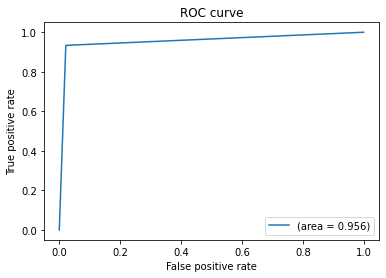

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import load_model
model = load_model("/content/drive/My Drive/capsCovid_2_capsule_epoch15.h5" , custom_objects={'PrimaryCap': PrimaryCap,'CapsuleLayer':CapsuleLayer,'Length':Length})

original_dir = '/content/drive/MyDrive/XRAY'
batch_size = 32
validation_split = 0.25

# all data in train_dir and val_dir which are alias to original_data. (both dir is temporary directory)
# don't clear base_dir, because this directory holds on temp directory.
base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1)



from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )


test_generator=datagen.flow_from_directory(directory=val_dir,batch_size=32, shuffle=False)

true = []
false = []
y_pred1 = []
y_pred2 = []

result = model.predict_generator(test_generator, steps=int(646 / 32)+1)

y_pred = np.argmax(result, axis=-1)

count=0
for i in test_generator.classes:
  if i ==0:
    false.append(i)
    y_pred2.append(y_pred[count])
  elif i ==1:
    true.append(i)
    y_pred1.append(y_pred[count])
  count+=1
  




from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(true, y_pred1)
tp = tpr_keras
print(tpr_keras)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(false, y_pred2)
fp = fpr_keras
print(fpr_keras)
auc_rf = auc(fp, tp)
plt.plot(fp,tp,label="(area = {:.3f})".format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()